<a href="https://colab.research.google.com/github/Av01/Reinforcement-Learning/blob/master/VanillaPolicyGrads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [0]:
#import and initialize gym environment
!pip install gym
!pip install "gym[atari]"
!apt-get install python-opengl -y
!apt-get install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1      

In [0]:
def to_gray(img):
  newImg = img[:,:,0] + img[:,:,1] + img[:,:,2]
  newImg = (1/(3*255))*newImg
  return newImg

def pre_process(image,width,height):  #bugged
  img = image
  if len(img.shape) > 2:
    img = to_gray(img)
  m = int(img.shape[0]/width)
  n = int(img.shape[1]/height)
  newImg = np.zeros((width,height))
  for i in range(width):
    for j in range(height):
      if n > 1 and m > 1:
        newImg[i,j] = np.mean(img[(i*m):((i+1)*m-1),(j*n):((j+1)*n-1)])
      else:
        if n == 0:
            n = 1
        if m == 0:
            m = 1
        if m == 1 and n == 1:
          newImg[i,j] = img[i*m,i*n]
        elif n == 1:
          newImg[i,j] = img[(i*m):((i+1)*m-1),j*n]
        elif m == 1:
          newimg[i,j] = img[i*m,(j*n):((j+1)*n-1)]
  return newImg
      
def pre_process1(image,width,height):
  img = image
  if len(img.shape) > 2:
    img = to_gray(img)
  m = int(img.shape[0]/width)
  n = int(img.shape[1]/height)
  newImg = np.zeros((width,height))
  for i in range(width):
    for j in range(height):
      newImg[i,j] = img[i*m,j*n]
  return newImg

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[[0.01220044 0.01220044 0.01220044 ... 0.01830065 0.01830065 0.01830065]
 [0.01830065 0.01830065 0.01830065 ... 0.01830065 0.01830065 0.01830065]
 [0.01830065 0.01830065 0.01830065 ... 0.01830065 0.01830065 0.01830065]
 ...
 [0.01830065 0.01830065 0.01830065 ... 0.01830065 0.01830065 0.01830065]
 [0.08714597 0.08714597 0.08714597 ... 0.08714597 0.08714597 0.08714597]
 [0.2248366  0.2248366  0.2248366  ... 0.2248366  0.2248366  0.2248366 ]]
(50, 50)
Observation space: Box(210, 160, 3)
Action space: Discrete(6)


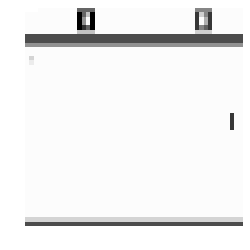

In [0]:
import gym
env = gym.make("Pong-v0")
env.reset()
plt.axis('off')
img = pre_process(env.render('rgb_array'),50,50)
print(img)
plt.imshow(img)
print(img.shape)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

In [0]:
class Policy_network:
  def generate_network(self,device='/cpu:0'):
    tf.reset_default_graph()
    with tf.device(device):
      self.w = 50
      self.h = 50
      self.stride = 10
      self.actionN = 3
      self.X = tf.placeholder(tf.float32,shape = (None,2,50,50))
      self.diff = tf.reshape(self.X[:,0,:,:] - self.X[:,1,:,:],shape = (-1,50,50,1))
      self.ConvW = tf.get_variable("Conv_weight",shape=(10,10,1,3),initializer=tf.initializers.random_normal(),trainable=True)
      self.L1 = tf.nn.conv2d(self.diff,self.ConvW,[1,self.stride,self.stride,1],padding='VALID')
      self.flat_L1 = tf.reshape(self.L1,(-1,75))
      self.fcW = tf.get_variable("Fully_Connected",shape=(75,self.actionN),initializer=tf.initializers.random_normal(),trainable=True)
      self.fcL = tf.matmul(self.flat_L1,self.fcW)
      self.policy = tf.nn.softmax(self.fcL,axis=1)
      print(self.policy.shape)
      self.action = tf.placeholder(tf.float32,shape = (None,1))
      self.oneHotAction = tf.reshape(tf.one_hot(tf.dtypes.cast(self.action,tf.int32),self.actionN,axis=1),(-1,3))
      print(self.oneHotAction.shape)
      self.advantage = tf.placeholder(tf.float32,shape = (None,1))
      self.logpi = tf.reduce_sum(tf.multiply(tf.log(self.policy + 0.00001),self.oneHotAction),axis = 1,keepdims=True)
      print(self.logpi.shape)
      self.loss = -tf.reduce_sum(tf.multiply(self.logpi,self.advantage))
      print(self.loss.shape)
      self.optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(self.loss)
      self.init = tf.global_variables_initializer()

In [0]:
class Buffer():
  buffer = []
  size = 0
  maxSize = 100
  
  def add(self,traj):
    self.buffer.append(traj)
    self.size += 1
    if self.size > self.maxSize:
      self.buffer = self.buffer[1:]
      self.size -= 1
    
  def empty(self):
    self.buffer = []
    
  def sample(self):
    index = np.random.randint(0,self.size)
    return self.buffer[index]

In [0]:
def run_episode(sess,network,buffer):
  epsilon = 0
  env.reset()
  o = pre_process(env.render('rgb_array'),50,50)
  frame = [o]*2
  d = True
  TotalR = 0
  pR = 0
  traj = []
  for i in range(1000):
    step = [np.array(frame)]
    if np.random.rand() < epsilon:
      a = np.random.choice([1,2,3],1)
      epsilon *= 0.9995
    else:
      policy = sess.run(network.policy,feed_dict = {network.X : np.array([frame])})[0]
#       print(policy)
      a = np.argmax(policy) + 1
    _,r,d,_ = env.step(a)
    if r > 0:
      pR += r
    TotalR += r
    frame.append(pre_process(env.render('rgb_array'),50,50))
    frame = frame[1:]
    assert len(frame) == 2
    step.extend([a-1,r])
#     print(np.array(step[0]).shape)
    traj.append(step)
    while not d:
      break
  print("Total Reward for trajectory: ",TotalR," Positive Reward: ",pR, "Steps: ",i+1)
  buffer.add(traj)
  
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def animate(frames):
  plt.figure(figsize=(frames[0].shape[1]/72, frames[0].shape[0]/72),dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  animateFun = lambda i: patch.set_data(frames[i])
  ani = matplotlib.animation.FuncAnimation(plt.gcf(), animateFun, frames=len(frames), interval = 50)
  return HTML(ani.to_jshtml())


def test_code(sess,network,random = False):
  s = env.reset()
  o = np.array(pre_process(env.render('rgb_array'),50,50))
  frame = [o] * 2
  display = []
  T_r = 0
  d = False
  while not d:
    if random:
      a = np.random.choice([1,2,3],1)
    else:
      a = np.argmax(sess.run(network.policy,feed_dict = {network.X : np.array([frame])})[0]) + 1
    s1,r,d,_ = env.step(a)
    display.append(to_gray(env.render('rgb_array')))
    frame.append(pre_process(env.render('rgb_array'),50,50))
    frame = frame[1:]
    assert len(frame) == 2
    s = s1
    T_r += r
    if len(display) == 1500:
      break
  display.append(to_gray(env.render('rgb_array')))
  print("Reward achieved: ", T_r)
  animate(display)
  return display
  
  
  
def train_network(sess,network,traj):
  X = []
  actions = []
  adv = []
  for step in traj:
#     print(np.array(step[0]))
#     break
    X.append(step[0])
    actions.append(step[1])
    adv.append(step[2])
#   print("Steps: ",len(X),len(actions),len(adv))
  _,loss = sess.run([network.optimizer,network.loss],feed_dict = {network.X : np.array(X),network.action : np.reshape(actions,(-1,1)),network.advantage : np.reshape(adv,(-1,1))})
  print("Loss :",loss)
  

(?, 3)
(?, 3)
(?, 1)
()
Reward achieved:  -9.0
Episode:  1
Total Reward for trajectory:  -12.0  Positive Reward:  0 Steps:  1000
Loss : 9.705633
Loss : 9.650223
Loss : 9.595253
Loss : 9.540722
Loss : 9.486626
Episode:  2
Total Reward for trajectory:  -18.0  Positive Reward:  0 Steps:  1000
Loss : 9.432961
Loss : 9.379723
Loss : 9.32691
Loss : 12.899363
Loss : 9.242428
Episode:  3
Total Reward for trajectory:  -18.0  Positive Reward:  0 Steps:  1000
Loss : 9.190718
Loss : 12.74781
Loss : 12.661051
Loss : 12.575346
Loss : 15.376882
Episode:  4
Total Reward for trajectory:  -20.0  Positive Reward:  0 Steps:  1000
Loss : 9.04022
Loss : 15.308608
Loss : 8.983245
Loss : 8.933489
Loss : 12.343824
Episode:  5
Total Reward for trajectory:  -17.0  Positive Reward:  0 Steps:  1000
Loss : 8.854931
Loss : 8.806236
Loss : 13.512562
Loss : 15.1562195
Loss : 15.096378
Episode:  6
Total Reward for trajectory:  -18.0  Positive Reward:  0 Steps:  1000
Loss : 15.037329
Loss : 13.338787
Loss : 13.779024
Lo

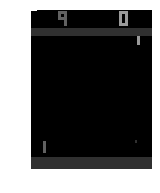

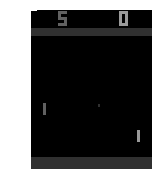

In [0]:
episodes = 300
device = tf.test.gpu_device_name()
size = 1000
trainN = 5
buffer = Buffer()
buffer.empty()
policy = Policy_network()
policy.generate_network(device)
display1 = []
display2 = []
with tf.Session() as sess:
  sess.run(policy.init)
  display1 = test_code(sess,policy)
  for i in range(episodes):
    print("Episode: ", i+1)
    run_episode(sess,policy,buffer)
    for j in range(trainN):
      train_network(sess,policy,buffer.sample())
  display2 = test_code(sess,policy)

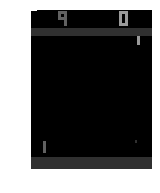

In [0]:
animate(display1)

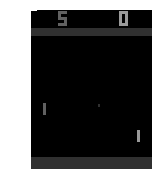

In [0]:
animate(display2)

In [0]:
policy.ConvW.read_value

<bound method RefVariable.read_value of <tf.Variable 'Conv_weight:0' shape=(10, 10, 1, 3) dtype=float32_ref>>

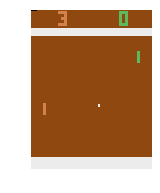

In [0]:
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML
def animate(frames):
  plt.figure(figsize=(frames[0].shape[1]/72, frames[0].shape[0]/72),dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  animateFun = lambda i: patch.set_data(frames[i])
  ani = matplotlib.animation.FuncAnimation(plt.gcf(), animateFun, frames=len(frames), interval = 50)
  return HTML(ani.to_jshtml())

s = env.reset()
o = np.array(env.render('rgb_array'))
display = []
T_r = 0
d = False
while not d:
      a = np.random.choice([1,2,3],1)
      s1,r,d,_ = env.step(a)
      display.append(np.array(env.render('rgb_array')))
      s = s1
      T_r += r
      if len(display) == 200:
        break
display.append(np.array(env.render('rgb_array')))
animate(display)